# Day 8: Hyperparameter Tuning

In this notebook, we’ll explore:

- Why hyperparameters matter
- Grid Search (exhaustive but costly)
- Random Search (faster, often surprisingly effective)
- Bayesian Optimization (guided search)
- Importance of cross-validation
- Comparing runtime vs. performance


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer, Real


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.6 MB/s eta 0:00:00


In [3]:
# Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Baseline Model: Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

baseline_mse = mean_squared_error(y_test, y_pred)
print("Baseline Random Forest MSE:", baseline_mse)

Baseline Random Forest MSE: 7466.037018788755


In [5]:
# Grid Search
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=3,
                           scoring="neg_mean_squared_error",
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best Params (Grid Search):", grid_search.best_params_)
print("Best Score (Grid Search):", -grid_search.best_score_)

Best Params (Grid Search): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (Grid Search): 8932.084420551786


In [6]:
# Random Search
param_dist = {
    "n_estimators": np.arange(50, 300, 10),
    "max_depth": [None] + list(np.arange(5, 30, 5)),
    "min_samples_split": np.arange(2, 15)
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=20,
                                   cv=3,
                                   scoring="neg_mean_squared_error",
                                   random_state=42,
                                   n_jobs=-1)

random_search.fit(X_train, y_train)
print("Best Params (Random Search):", random_search.best_params_)
print("Best Score (Random Search):", -random_search.best_score_)

Best Params (Random Search): {'n_estimators': np.int64(240), 'min_samples_split': np.int64(4), 'max_depth': None}
Best Score (Random Search): 8960.890054396477


In [9]:
# Bayesian Optimization
search_spaces = {
    "n_estimators": Integer(50, 300),
    "max_depth": Integer(5, 30),
    "min_samples_split": Integer(2, 15)
}

bayes_search = BayesSearchCV(RandomForestRegressor(random_state=42),
                             search_spaces,
                             n_iter=20,
                             cv=3,
                             scoring="neg_mean_squared_error",
                             random_state=42,
                             n_jobs=-1)

bayes_search.fit(X_train, y_train)
print("Best Params (Bayesian Optimization):", bayes_search.best_params_)
print("Best Score (Bayesian Optimization):", -bayes_search.best_score_)

Best Params (Bayesian Optimization): OrderedDict({'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 295})
Best Score (Bayesian Optimization): 8877.605833744674


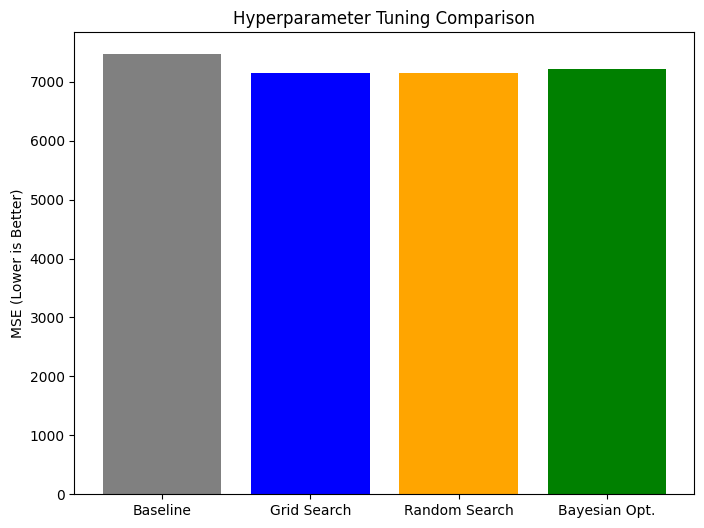

In [10]:
# Visualization: Comparison of methods
methods = ["Baseline", "Grid Search", "Random Search", "Bayesian Opt."]
scores = [
    baseline_mse,
    mean_squared_error(y_test, grid_search.best_estimator_.predict(X_test)),
    mean_squared_error(y_test, random_search.best_estimator_.predict(X_test)),
    mean_squared_error(y_test, bayes_search.best_estimator_.predict(X_test))
]

plt.figure(figsize=(8,6))
plt.bar(methods, scores, color=["gray", "blue", "orange", "green"])
plt.ylabel("MSE (Lower is Better)")
plt.title("Hyperparameter Tuning Comparison")
plt.show()

# Key Takeaway
Hyperparameter tuning feels like adjusting the dials on a machine —
too much in one direction, and the model underfits
too much in another, and it overfits.
Smart tuning unlocks a model’s true potential without overcomplicating things.